### Fitting a Bayesian Bernoulli mixture model with known number of groups

Learning algorithm: MCMC - Gibbs sampler

In [2]:
import os, pickle
import numpy as np
from numpy import log, sum, exp, prod
from numpy.random import beta, binomial, dirichlet, uniform, gamma, seed, multinomial, gumbel, rand
from imp import reload
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

os.chdir("C:\\Users\\Alexander\\Documents\\\Github\\bmm_mix")

from bernmix.utils import bmm_utils as bmm

%matplotlib inline
sns.set(color_codes=True)

In [3]:
reload(bmm)

<module 'bernmix.utils.bmm_utils' from 'C:\\Users\\Alexander\\Documents\\GitHub\\bmm_mix\\bernmix\\utils\\bmm_utils.py'>

Simulate data from data generating process:

In [4]:
#seed(12)

N = 10**4         # number of observations  
K = 3            # number of mixture components
D = 50           # dimensions / number of features     

# True states of unknown parameters:
alphas = gamma(shape=5, size=K)                            # shape parameter
p_true = dirichlet(alpha = alphas, size = 1)[0]              # mixture weights
theta_true = beta(a = .7, b = .9, size = K*D).reshape(D,K)           # success probabilities for Bernoulli distributions

Generate data from mixture model:

In [5]:
X, Z = bmm.sample_bmm(N, p_true, theta_true)

Sampling from 50 dimensional Bernoulli mixture with 3 mixture components.
Number of random draws: 10000


### Learning via Gibbs algorithm

Set initial values for parameters:

In [6]:
MC = 2000        # Monte Carlo runs
burn_in = 500    # discard those draws for burn-in
K = 3                            # number of clusters
N, D = X.shape[0], X.shape[1]          # number of observations and features

p_draws = np.empty((MC,K))
theta_draws = np.empty((MC,X.shape[1],K))

alphas = gamma(shape=5, size=K)               # shape parameters for prior
p_0 = dirichlet(alpha = alphas, size = 1)[0]
#p_0 = np.array([1/K]*K)                     # uninformative
theta_0 = beta(a = 1.3, b = 1.7, size = K*D).reshape(D,K)    # prior
p_draws[0,:], theta_draws[0,:,:] = p_0, theta_0 

gammas, deltas = gamma(shape=1.5, size=K), rand(K)     # uniform random draws   

Sample from full conditional posterior distributions of model parameters $\mathbf{p}$ and $\Theta$:

In [7]:
for i in range(1,MC):   
    if i%500 == 0:   
        print("Iter.",i)
        
    p_draws[i,:], theta_draws[i,:,:] = bmm.gibbs_pass(p_draws[i-1,:], theta_draws[i-1,:,:], X, alphas = alphas, 
                                                      hyper_para = {'gammas': gammas, 'deltas': deltas})
print("Finished!")

Iter. 500
Iter. 1000
Iter. 1500
Finished!


Compute Bayes estimates under $L_{2}$:

In [9]:
theta_bayes = np.mean(theta_draws[burn_in:,:, :],axis=0)
print(theta_bayes.shape)
theta_true

p_bayes = np.mean(p_draws[burn_in:,],axis=0)
print(p_bayes)
print(p_true)

(50, 3)
[0.4088002  0.24371426 0.34748555]
[0.2446058  0.40324763 0.35214657]


Posterior density of $p_0$:

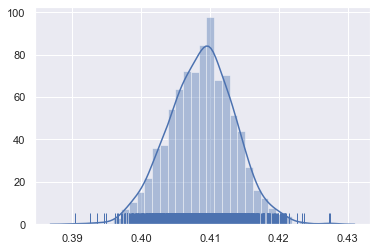

In [10]:
sns.distplot(p_draws[burn_in:, 0], kde=True, rug=True)
#plt.xlabel("$p_0$")

### Plot traces and density estimates:

Markov chain draws for $\mathbf{p} = (p_{1}, p_{2}, p_{3})$:

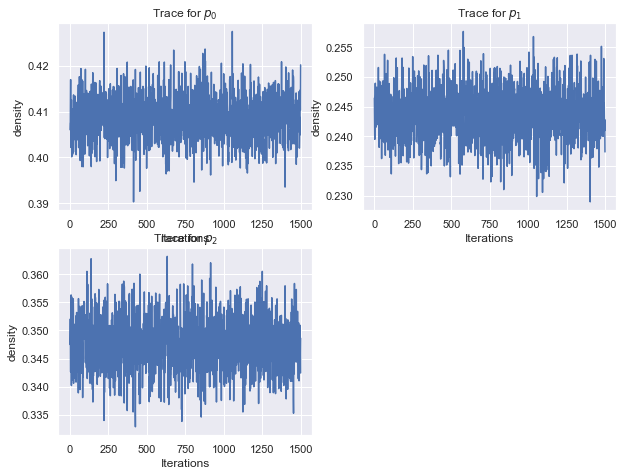

In [13]:
#%matplotlib inline
plt.figure(figsize=(10, 20))
for j in range(p_draws.shape[1]):
    plt.subplot(5,2,j+1)
    plt.plot(p_draws[burn_in:, j]);
    plt.xlabel("Iterations"); plt.ylabel("density")
    plt.title('Trace for $p_{%d}$' % j)


Chains for $\Theta_{1} = (\theta_{1,1}, \theta_{2,1},..., \theta_{50,1})$:

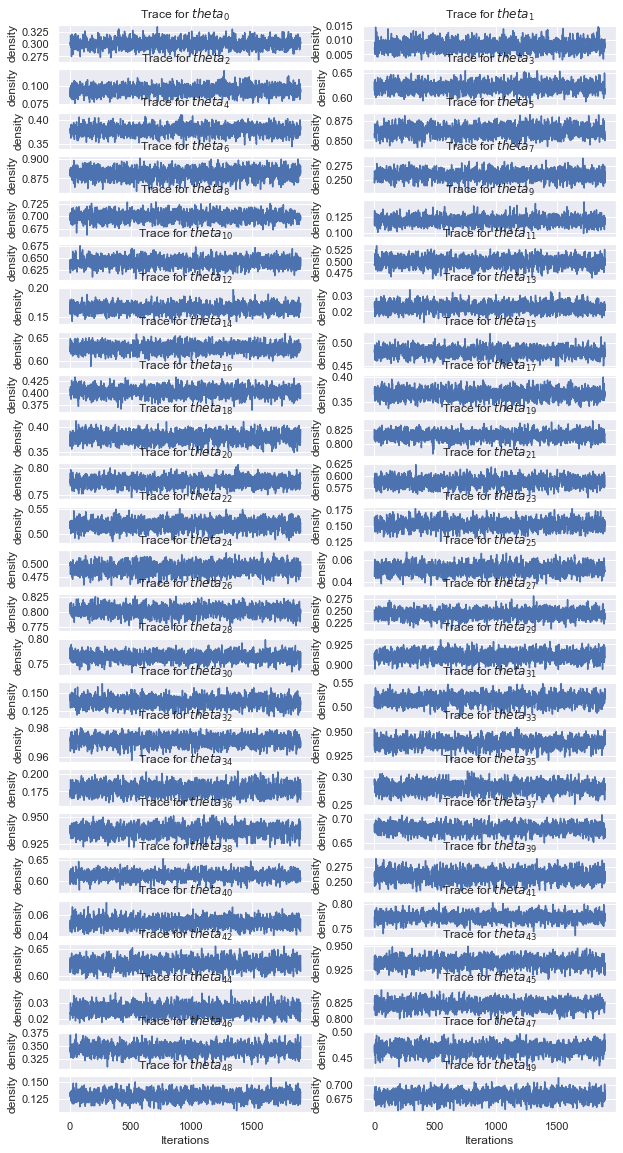

In [12]:
#%matplotlib inline
plt.figure(figsize=(10, 20))
for j in range(theta_draws.shape[1]):
    plt.subplot(25,2,j+1)
    plt.plot(theta_draws[100:,j, 1]);              # component 1
    plt.xlabel("Iterations")
    plt.ylabel("density")
    plt.title('Trace for $theta_{%d}$' % j)


<Figure size 720x1440 with 0 Axes>

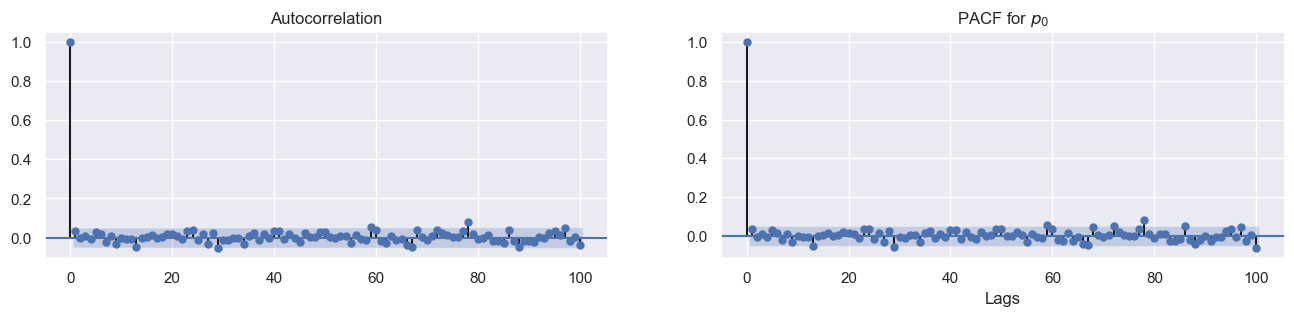

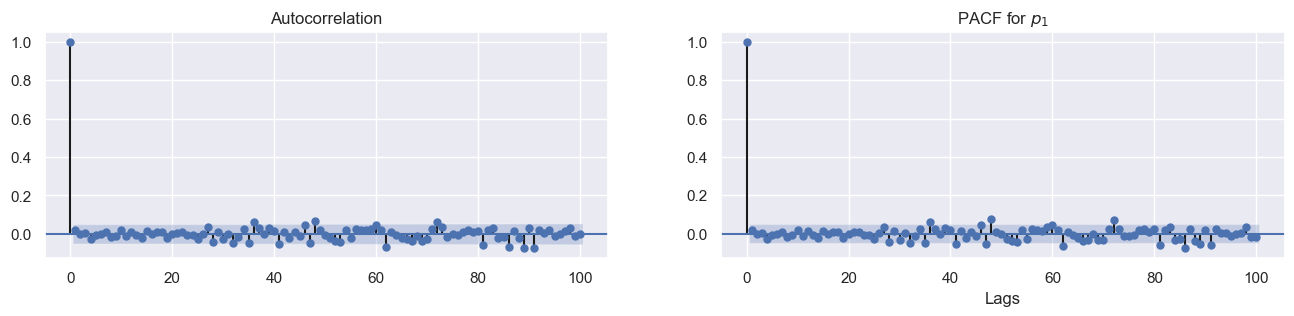

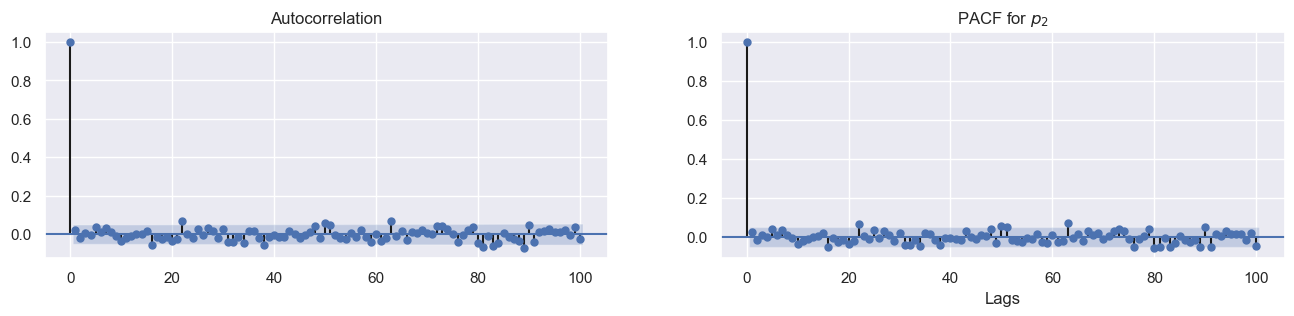

In [25]:
# Calculate ACF and PACF upto 50 lags
#acf_50 = acf(df.value, nlags=50)
#pacf_50 = pacf(df.value, nlags=50)

plt.figure(figsize=(10, 20))
for j in range(p_draws.shape[1]):
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    plot_acf(p_draws[burn_in:, j], lags=100, ax=axes[0])
    plt.xlabel("Lags"); 
    plt.title('ACF for $p_{%d}$' % j)
    plot_pacf(p_draws[burn_in:, j], lags=100, ax=axes[1])
    #plt.xlabel("Lags"); #plt.ylabel("PACF")
    plt.title('PACF for $p_{%d}$' % j)
